<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/auto_lib/%5Btabular%5D_pycaret_superai2_finalHackathon_6to7aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#lib & install

In [1]:

!pip install missingno

Downloading...
From: https://drive.google.com/uc?id=11hyGw_8g7qBhhWYLoTonrriMDjZ9sRFO
To: /content/DataSet.zip
100% 1.16G/1.16G [00:09<00:00, 119MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!unzip '/content/DataSet.zip'
!unzip '/content/DataSet/IOT.zip'

Archive:  /content/DataSet.zip
   creating: DataSet/
 extracting: DataSet/DS.zip          
 extracting: DataSet/Image.zip       
 extracting: DataSet/IOT.zip         
 extracting: DataSet/NLP_Train.zip   
 extracting: DataSet/Signal.zip      
Archive:  /content/DataSet/IOT.zip
  inflating: IOT_Test.csv            
  inflating: IOT_Train.csv           


#eda

In [3]:
import pandas as pd
import missingno as msno

<AxesSubplot:>

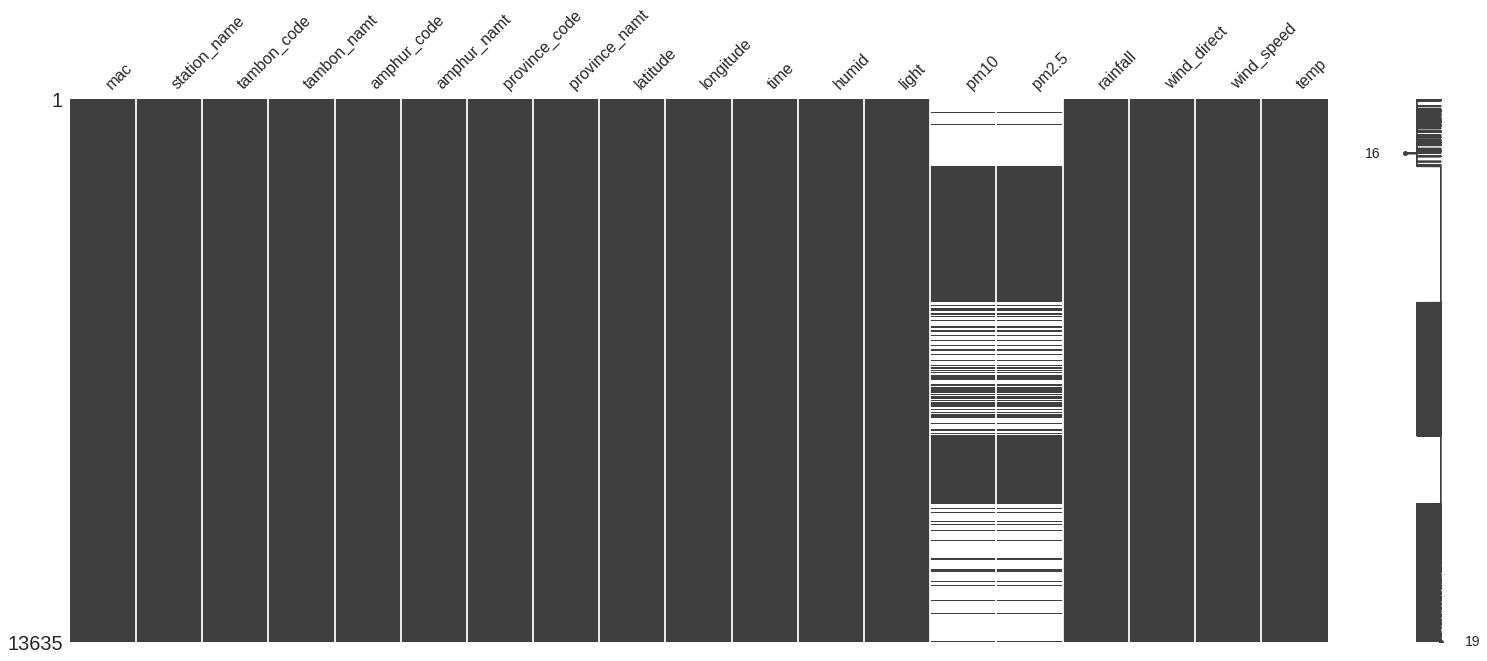

In [4]:
train = pd.read_csv('/content/IOT_Train.csv')
test = pd.read_csv('/content/IOT_Test.csv')

msno.matrix(train)

In [5]:
train = train.drop(1371)
train[train.temp.isna()]

,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,time,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,temp


#preprocess

In [6]:
#month and hour for train data 
train['month'] = train['time'].apply(lambda x: x.split('-')[1])
train['hour'] = train['time'].apply(lambda x: x.split('+')[1])
train.drop(['time'], axis=1)

train['hour'] = train['hour'].apply(lambda x: x.split(":")[0])
train['month'] = train['month'].apply(lambda x: int(x))
train['hour'] = train['hour'].apply(lambda x: int(x))

train.head(3)

# desired_cols = ['mac', 'station_name', 'tambon_code', 'tambon_namt', 'amphur_code',
#        'amphur_namt', 'province_code', 'province_namt', 'latitude',
#        'longitude', 'time', 'humid', 'light', 'rainfall',
#        'wind_direct', 'wind_speed', 'temp', 'month', 'hour']

,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,...,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,temp,month,hour
0,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,...,70.6,59.0,NaN,NaN,0.0,45.0,4.3,32.6,7,7
1,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,...,62.3,76.0,NaN,NaN,0.0,45.0,1.9,37.9,5,7
2,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,...,90.3,0.0,NaN,NaN,0.0,135.0,3.2,26.4,6,7


In [7]:
train['amphur_code'].dtype

dtype('int64')

#model

##XGRegressor

In [ ]:
s = (train.dtypes == 'int64') + (train.dtypes == 'float64')
num_cols = list(s[s].index)
num_cols = num_cols

num_cols.remove('pm10')
num_cols.remove('pm2.5')
num_cols.remove('temp')
print(num_cols)

['tambon_code', 'amphur_code', 'province_code', 'latitude', 'longitude', 'humid', 'light', 'rainfall', 'wind_direct', 'wind_speed', 'month', 'hour']


In [ ]:
x = train[num_cols]
x = x.fillna(int(0))
y = train.temp

from sklearn.model_selection import train_test_split
# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(x, y, random_state=8)

X_train.head(3)

,tambon_code,amphur_code,province_code,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,month,hour
10763,102601,1026,10,13.777972,100.569662,82.1,0.0,0.0,157.5,0.0,7,7
1433,300903,3009,30,15.112831,102.052114,91.4,0.0,0.0,90.0,0.0,7,7
6724,550404,5504,55,18.241106,100.690577,69.9,79.0,0.0,315.0,1.9,6,7


In [ ]:
from xgboost import XGBRegressor

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.8567156400314067


In [ ]:
#month and hour for test data
test['month'] = test['time'].apply(lambda x: x.split('-')[1])
test['hour'] = test['time'].apply(lambda x: x.split('+')[1])
test.drop(['time'], axis=1)

test['hour'] = test['hour'].apply(lambda x: x.split(":")[0])

test['month'] = test['month'].apply(lambda x: int(x))
test['hour'] = test['hour'].apply(lambda x: int(x))

test = test[num_cols]
test.head(1)

,tambon_code,amphur_code,province_code,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,month,hour
0,300903,3009,30,15.112831,102.052114,88.9,1.0,0.0,180.0,2.3,5,7


In [ ]:
import math

preds = my_model.predict(test)

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

submiss = pd.read_csv('/content/IOT_Test.csv')
submission = pd.DataFrame({'id': submiss['id'], 'temp': preds})
submission['temp'] = submission['temp'].apply(lambda x: truncate(x,1))
submission.head(3)

,id,temp
0,1,25.8
1,2,27.0
2,3,25.9


In [ ]:
submission.to_csv('IOT_Submit.csv', index=False)
from google.colab import files
files.download('IOT_Submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_cols

['tambon_code',
 'amphur_code',
 'province_code',
 'latitude',
 'longitude',
 'humid',
 'light',
 'rainfall',
 'wind_direct',
 'wind_speed',
 'month',
 'hour']

##pycaret
inspiration: 

https://pycaret.gitbook.io/docs/get-started/quickstart#setup
https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb

In [ ]:
!pip install pycaret[full] -q
!pip install -U --pre pycaret -q

!pip uninstall markupsafe -y
!pip install markupsafe==2.0.1

In [1]:
#restart runtime before continue
import markupsafe
print(markupsafe.__version__)

import jinja2
from pycaret.regression import *

2.0.1


In [8]:
train[train['temp'].isna()]
# train = train.drop(1371)

,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,...,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,temp,month,hour


In [9]:
help(setup)

Help on function setup in module pycaret.regression.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse.base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Union[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse.base.spmatrix, pandas.core.frame.DataFrame]], NoneType] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse.base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Union[Dict[str, list], NoneType] = None, numeric_features: Union[List[str], NoneType] = None, categorical_features: Union[List[str], NoneType] = None, date_features: Union[List[str], NoneType] = None, text_features: Union[List[str], NoneType] = None, ignore_features: Union[List[str], NoneType] = None, keep_features: Union[List[str], NoneType] = None, preprocess: bool = True, imputation_type: Union[str, N

In [10]:
train['time'] = pd.to_datetime(train['time'])
train['time']

0       2022-07-20 15:00:00+07:00
1       2022-05-16 09:00:00+07:00
2       2022-06-26 19:00:00+07:00
3       2022-07-16 04:00:00+07:00
4       2022-05-30 08:00:00+07:00
                   ...           
13630   2022-06-14 01:00:00+07:00
13631   2022-05-03 02:00:00+07:00
13632   2022-05-19 06:00:00+07:00
13633   2022-06-15 02:00:00+07:00
13634   2022-06-05 18:00:00+07:00
Name: time, Length: 13634, dtype: datetime64[ns, pytz.FixedOffset(420)]

In [16]:
set_up_na_krub = setup(
                   data = train, target = 'temp',
                   log_experiment = True, experiment_name = 'diamond',
                   ignore_features=['tambon_namt','amphur_namt', 'province_namt','pm10','pm2.5'],
                   date_features=['time'],
                   numeric_imputation='mean',
                   categorical_imputation='mode',
                   pca=True, verbose=False,
                   )

INFO:logs:PyCaret RegressionExperiment
INFO:logs:Logging name: diamond
INFO:logs:ML Usecase: MLUsecase.REGRESSION
INFO:logs:version 3.0.0.rc3
INFO:logs:Initializing setup()
INFO:logs:self.USI: ff15
INFO:logs:self.variable_keys: {'USI', 'display_container', 'html_param', 'y', 'transform_target_method_param', 'log_plots_param', '_ml_usecase', 'fold_groups_param', 'variable_keys', 'transform_target_param', 'gpu_param', 'exp_name_log', 'idx', 'n_jobs_param', 'fold_shuffle_param', '_all_metrics', 'logging_param', 'memory', '_available_plots', 'exp_id', 'y_train', 'seed', 'y_test', '_all_models_internal', 'pipeline', 'fold_generator', 'X', 'X_test', '_all_models', 'master_model_container', 'X_train', 'data', '_gpu_n_jobs_param', 'target_param'}
INFO:logs:Checking environment
INFO:logs:python_version: 3.7.13
INFO:logs:python_build: ('default', 'Apr 24 2022 01:04:09')
INFO:logs:machine: x86_64
INFO:logs:platform: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
INFO:logs:Memory: svmem(total=2733

In [17]:
best = compare_models()

INFO:logs:Initializing compare_models()
INFO:logs:compare_models(self=<pycaret.regression.oop.RegressionExperiment object at 0x7ff7ea97f290>, include=None, fold=None, round=4, cross_validation=True, sort=R2, n_select=1, budget_time=None, turbo=True, errors=ignore, fit_kwargs=None, groups=None, experiment_custom_tags=None, probability_threshold=None, verbose=True, parallel=None, caller_params={'self': <pycaret.regression.oop.RegressionExperiment object at 0x7ff7ea97f290>, 'include': None, 'exclude': None, 'fold': None, 'round': 4, 'cross_validation': True, 'sort': 'R2', 'n_select': 1, 'budget_time': None, 'turbo': True, 'errors': 'ignore', 'fit_kwargs': None, 'groups': None, 'experiment_custom_tags': None, 'engines': None, 'verbose': True, 'parallel': None, '__class__': <class 'pycaret.regression.oop.RegressionExperiment'>}, exclude=None)
INFO:logs:Checking exceptions
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.7834,1.1809,1.0861,0.9369,0.0373,0.0276,1.0930
rf,Random Forest Regressor,0.8051,1.2659,1.1247,0.9324,0.0385,0.0283,2.8660
gbr,Gradient Boosting Regressor,0.8679,1.3736,1.1712,0.9267,0.0404,0.0306,1.3420
lightgbm,Light Gradient Boosting Machine,1.0186,1.9120,1.3711,0.8979,0.0471,0.0362,0.1730
catboost,CatBoost Regressor,1.1075,2.0976,1.4352,0.8883,0.0498,0.0398,3.2810
knn,K Neighbors Regressor,1.0942,2.3827,1.5429,0.8725,0.0521,0.0382,0.0920
lr,Linear Regression,1.1106,2.4446,1.5621,0.8695,0.0533,0.0392,0.2960
ridge,Ridge Regression,1.1172,2.4994,1.5796,0.8665,0.0535,0.0393,0.0610
br,Bayesian Ridge,1.1218,2.5155,1.5848,0.8657,0.0537,0.0394,0.0600
dt,Decision Tree Regressor,1.1241,2.5940,1.6085,0.8614,0.0545,0.0392,0.1070


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

INFO:logs:Initializing Linear Regression
INFO:logs:Total runtime is 1.6891956329345702e-05 minutes
INFO:logs:SubProcess create_model() called ==================================
INFO:logs:Initializing create_model()
INFO:logs:create_model(self=<pycaret.regression.oop.RegressionExperiment object at 0x7ff7ea97f290>, estimator=lr, fold=KFold(n_splits=10, random_state=None, shuffle=False), round=4, cross_validation=True, predict=True, fit_kwargs={}, groups=None, refit=False, probability_threshold=None, experiment_custom_tags=None, verbose=False, system=False, add_to_model_list=True, metrics=None, display=<pycaret.internal.display.display.CommonDisplay object at 0x7ff80a6b9ad0>, model_only=True, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Linear Regression Imported successfully
INFO:logs:Starting cr

INFO:logs:Creating Dashboard logs
INFO:logs:Model: Extra Trees Regressor
INFO:logs:Logged params: {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 1737, 'verbose': 0, 'warm_start': False}
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(self=<pycaret.regression.oop.RegressionExperiment object at 0x7ff7ea97f290>, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=1737), probability_threshold=None, encoded_labels=False, raw_score=False, drift_report=False, round=4, verbose=False, ml_usecase=None, preprocess=True, replace_labels_in_column=<function _SupervisedExperiment.predict_model.<locals>.replace_labels_in_column at 0x7ff7ea8115f0>)
INFO:logs:Checking exceptions
INFO:logs:Preloading l

In [21]:
evaluate_model(best)

##predict

In [28]:
#month and hour for test data
test['month'] = test['time'].apply(lambda x: x.split('-')[1])
test['hour'] = test['time'].apply(lambda x: x.split('+')[1])
test.drop(['time'], axis=1)

test['hour'] = test['hour'].apply(lambda x: x.split(":")[0])

test['month'] = test['month'].apply(lambda x: int(x))
test['hour'] = test['hour'].apply(lambda x: int(x))

test['time'] = pd.to_datetime(test['time'])

test.head(1)

,id,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,...,time,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,month,hour
0,1,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,...,2022-05-23 04:00:00+07:00,88.9,1.0,NaN,NaN,0.0,180.0,2.3,5,7


In [30]:
preds = predict_model(best, data=test)

submission = pd.DataFrame({'id': test['id'], 'temp': preds['Label']})
submission['temp'] = submission['temp'].apply(lambda x: round(x,1))
submission.head(3)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(self=<pycaret.regression.oop.RegressionExperiment object at 0x7ff7ea97f290>, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=1737), probability_threshold=None, encoded_labels=False, raw_score=False, drift_report=False, round=4, verbose=True, ml_usecase=None, preprocess=True, replace_labels_in_column=<function _SupervisedExperiment.predict_model.<locals>.replace_labels_in_column at 0x7ff7e6636170>)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries


INFO:logs:Set up data.


,id,temp
0,1,26.3
1,2,27.3
2,3,26.0


In [31]:
submission.to_csv('IOT_Submit.csv', index=False)

In [34]:
from google.colab import files
files.download('IOT_Submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>